In [1]:
import pandas as pd

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

In [227]:
stas = pd.read_csv('../DeconstructingGastrulation-Data/tracked_data.csv')

stas.head()

,Unnamed: 0.1,Unnamed: 0,x,y,z,frame,particle,dx,dy,dz
0,0,0,252.766403,24.680962,103.450500,1,0,NaN,NaN,NaN
1,1,1,252.504501,24.682747,103.450500,1,1,NaN,NaN,NaN
2,2,2,248.314102,24.750181,103.450500,1,2,NaN,NaN,NaN
3,3,3,247.528397,24.807440,109.474197,1,3,NaN,NaN,NaN
4,4,4,246.218903,24.629951,106.069504,1,4,NaN,NaN,NaN


In [232]:
tracked_and_rescaled = stas.copy()


tracked_and_rescaled['x'] = tracked_and_rescaled['x'] - tracked_and_rescaled['x'].mean()-25
tracked_and_rescaled['y'] = (tracked_and_rescaled['y'] - tracked_and_rescaled['y'].mean())*1.08
tracked_and_rescaled['z'] = tracked_and_rescaled['z'] - tracked_and_rescaled['z'].mean()+10

angle = -np.pi/180*8
tracked_and_rescaled['x'], tracked_and_rescaled['z'] = tracked_and_rescaled['x']*np.cos(angle) - tracked_and_rescaled['z']*np.sin(angle), tracked_and_rescaled['x']*np.sin(angle) + tracked_and_rescaled['z']*np.cos(angle)

s = 3.6
tracked_and_rescaled['x'] = tracked_and_rescaled['x']/s
tracked_and_rescaled['y'] = tracked_and_rescaled['y']/s
tracked_and_rescaled['z'] = tracked_and_rescaled['z']/s

# redefine dx, dy, dz
tracked_and_rescaled['dx'] = tracked_and_rescaled['x'].groupby(tracked_and_rescaled['particle']).diff()
tracked_and_rescaled['dy'] = tracked_and_rescaled['y'].groupby(tracked_and_rescaled['particle']).diff()
tracked_and_rescaled['dz'] = tracked_and_rescaled['z'].groupby(tracked_and_rescaled['particle']).diff()

tracked_and_rescaled.to_csv('../DeconstructingGastrulation-Data/tracked_data_rescaled.csv', index=False)

In [91]:
# count nans in dx
print('percefntage of NaNs in dx:', tracked_and_rescaled['dx'].isna().sum()/len(tracked_and_rescaled['dx'])*100)

percefntage of NaNs in dx: 18.563208084147494


In [52]:
import h5py
import numpy as np

with h5py.File('../CodePass2/runs/stas_comments_2.hdf5', 'r') as f:
    sim = np.array(f['x'])

    

In [4]:
# interactive plotting
import matplotlib.pyplot as plt
from IPython.display import HTML




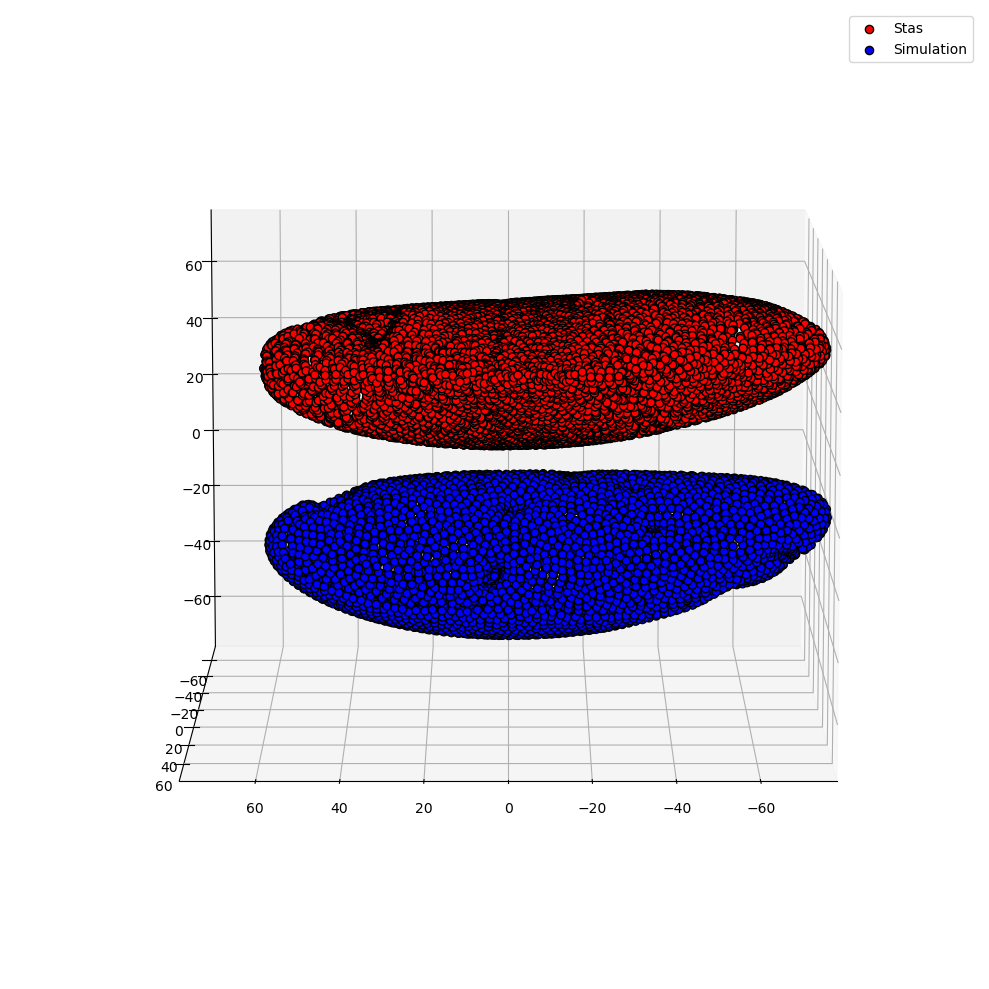

In [233]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# make animation
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize = (10,10), tight_layout = True)
ax = fig.add_subplot(111, projection='3d',)



def func(i):
    ax.clear()
    
    frame1 = tracked_and_rescaled[tracked_and_rescaled['frame'] == i+1]



    ax.scatter(frame1['x'], frame1['y'], frame1['z']+35, c='r', marker='.', alpha = 1, label = 'Stas', s = 140, edgecolors='k', zorder = 10)

    x,y,z = sim[i*50].T


    ax.scatter(x, y, z-25, c='b', marker='.', alpha = 1, label = 'Simulation', s = 140, edgecolors='k')

    plt.xlim(-75,75)
    plt.ylim(-75,75)
    ax.set_zlim(-75,75)

    # set the camera angle
    ax.view_init(elev=10, azim=90)

    plt.legend()
    return ax

ani = FuncAnimation(fig, func, frames=np.arange(0, 20), interval=100)

ani.save('comparison_3.mp4', writer='ffmpeg', fps=2)

plt.show()

In [144]:
tracked_and_rescaled[tracked_and_rescaled.frame == 5]

,Unnamed: 0.1,Unnamed: 0,x,y,z,frame,particle,dx,dy,dz
42668,42668,42668,-17.322857,-95.599053,1.152255,5,1,0.259353,-0.002544,-0.036450
42669,42669,42669,-17.655110,-95.546206,0.669998,5,0,0.222903,0.022245,-0.295803
42670,42670,42670,-21.472476,-95.526224,1.735446,5,2,-0.222903,-0.025440,0.295803
42671,42671,42671,-22.554736,-95.661780,5.325709,5,4,0.555156,0.002233,0.186454
42672,42672,42672,-26.258548,-95.599317,5.317294,5,5,0.222903,0.007999,-0.295803
...,...,...,...,...,...,...,...,...,...,...
53295,53295,53295,-99.504941,85.356952,14.817984,5,10652,-0.741609,0.000000,0.368702
53296,53296,53296,-103.362964,85.356952,17.475984,5,10653,-0.668711,0.000560,0.887401
53297,53297,53297,-73.533368,85.898238,11.432393,5,10657,-0.409357,0.023780,0.850959
53298,53298,53298,-75.166592,85.743545,12.984298,5,10658,-0.186454,-0.097888,0.555156


In [248]:
from scipy.spatial.distance import cdist


def get_scores(time_index, N_closest = 5, timescale = 50):
    sim_d = (sim[timescale*(time_index+1)] - sim[timescale*time_index])
    sim_poss = sim[timescale*time_index]

    scores = np.empty(sim_poss.shape[0])
    for i in range(sim_poss.shape[0]):
        print(f"{int(i/sim_poss.shape[0]*100)}%", end = '\r')

        data = tracked_and_rescaled[tracked_and_rescaled.frame == time_index]

        # calculate the distance between sp and all points in tracked_and_rescaled
        d = cdist([sim_poss[i]], data[['x', 'y', 'z']].values, 'euclidean')
        # find the closest points
        closest = np.argsort(d)[0][:N_closest]

        # get average dx, dy, dz in data
        dxs = data['dx'].iloc[closest].dropna()
        dys = data['dy'].iloc[closest].dropna()
        dzs = data['dz'].iloc[closest].dropna()

        if all(np.isnan(dxs)) or all(np.isnan(dys)) or all(np.isnan(dzs)):
            continue

        dx = dxs.mean()
        dy = dys.mean()
        dz = dzs.mean()
        
        # print("Here")
        # # compute the score
        # print(sim_d[i])
        # print(dx, dy, dz,)
        # print(dxs.std(), dys.std(), dzs.std())

        if np.isnan(dx) or np.isnan(dy) or np.isnan(dz):
            continue

        data_d_vector = np.array([dx, dy, dz])
        sim_d_vector = sim_d[i]

        # normalize
        data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)
        sim_d_vector = sim_d_vector / np.linalg.norm(sim_d_vector)

        # compute the score
        score = np.dot(data_d_vector, sim_d_vector)

        # score = np.mean([np.abs(dx), np.abs(dy), np.abs(dz)])
        # score = np.mean([np.abs(sim_d[i][0] - dx), np.abs(sim_d[i][1] - dy), np.abs(sim_d[i][2] - dz)])
        scores[i] = score

    return scores

time_indices = [1,2,3,4,5,6]
N_closest = [3,5,10,15]
timescales = [10, 20, 50, 70]
overview = np.empty((len(time_indices), len(N_closest), len(timescales)))

for i, time_index in enumerate(time_indices):
    for j, N in enumerate(N_closest):
        for k, timescale in enumerate(timescales):
            print(f"time_index: {time_index}, N: {N}, timescale: {timescale}")
            scores = get_scores(time_index, N, timescale)
            overview[i,j,k] = np.mean(scores)

time_index: 1, N: 3, timescale: 10
time_index: 1, N: 3, timescale: 20
time_index: 1, N: 3, timescale: 50
time_index: 1, N: 3, timescale: 70
time_index: 1, N: 5, timescale: 10
time_index: 1, N: 5, timescale: 20
time_index: 1, N: 5, timescale: 50
time_index: 1, N: 5, timescale: 70
time_index: 1, N: 10, timescale: 10
time_index: 1, N: 10, timescale: 20
time_index: 1, N: 10, timescale: 50
time_index: 1, N: 10, timescale: 70
time_index: 1, N: 15, timescale: 10
time_index: 1, N: 15, timescale: 20
time_index: 1, N: 15, timescale: 50
time_index: 1, N: 15, timescale: 70
time_index: 2, N: 3, timescale: 10


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 2, N: 3, timescale: 20


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 2, N: 3, timescale: 50
time_index: 2, N: 3, timescale: 70
time_index: 2, N: 5, timescale: 10
time_index: 2, N: 5, timescale: 20
time_index: 2, N: 5, timescale: 50
time_index: 2, N: 5, timescale: 70
time_index: 2, N: 10, timescale: 10
time_index: 2, N: 10, timescale: 20
time_index: 2, N: 10, timescale: 50
time_index: 2, N: 10, timescale: 70
time_index: 2, N: 15, timescale: 10
time_index: 2, N: 15, timescale: 20
time_index: 2, N: 15, timescale: 50
time_index: 2, N: 15, timescale: 70
time_index: 3, N: 3, timescale: 10
time_index: 3, N: 3, timescale: 20


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 3, N: 3, timescale: 50


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 3, N: 3, timescale: 70
time_index: 3, N: 5, timescale: 10
time_index: 3, N: 5, timescale: 20
time_index: 3, N: 5, timescale: 50
time_index: 3, N: 5, timescale: 70
time_index: 3, N: 10, timescale: 10
time_index: 3, N: 10, timescale: 20
time_index: 3, N: 10, timescale: 50
time_index: 3, N: 10, timescale: 70
time_index: 3, N: 15, timescale: 10
time_index: 3, N: 15, timescale: 20
time_index: 3, N: 15, timescale: 50
time_index: 3, N: 15, timescale: 70
time_index: 4, N: 3, timescale: 10
time_index: 4, N: 3, timescale: 20


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 4, N: 3, timescale: 50


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 4, N: 3, timescale: 70
time_index: 4, N: 5, timescale: 10
time_index: 4, N: 5, timescale: 20
time_index: 4, N: 5, timescale: 50
time_index: 4, N: 5, timescale: 70
time_index: 4, N: 10, timescale: 10
time_index: 4, N: 10, timescale: 20
time_index: 4, N: 10, timescale: 50
time_index: 4, N: 10, timescale: 70
time_index: 4, N: 15, timescale: 10
time_index: 4, N: 15, timescale: 20
time_index: 4, N: 15, timescale: 50
time_index: 4, N: 15, timescale: 70
time_index: 5, N: 3, timescale: 10


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 5, N: 3, timescale: 20


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 5, N: 3, timescale: 50


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 5, N: 3, timescale: 70


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 5, N: 5, timescale: 10
time_index: 5, N: 5, timescale: 20
time_index: 5, N: 5, timescale: 50
time_index: 5, N: 5, timescale: 70
time_index: 5, N: 10, timescale: 10
time_index: 5, N: 10, timescale: 20
time_index: 5, N: 10, timescale: 50
time_index: 5, N: 10, timescale: 70
time_index: 5, N: 15, timescale: 10
time_index: 5, N: 15, timescale: 20
time_index: 5, N: 15, timescale: 50
time_index: 5, N: 15, timescale: 70
time_index: 6, N: 3, timescale: 10


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 6, N: 3, timescale: 20


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 6, N: 3, timescale: 50


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\2583694154.py:44: RuntimeWarning: invalid value encountered in true_divide
  data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)


time_index: 6, N: 3, timescale: 70
time_index: 6, N: 5, timescale: 10
time_index: 6, N: 5, timescale: 20
time_index: 6, N: 5, timescale: 50
time_index: 6, N: 5, timescale: 70
time_index: 6, N: 10, timescale: 10
time_index: 6, N: 10, timescale: 20
time_index: 6, N: 10, timescale: 50
time_index: 6, N: 10, timescale: 70
time_index: 6, N: 15, timescale: 10
time_index: 6, N: 15, timescale: 20
time_index: 6, N: 15, timescale: 50
time_index: 6, N: 15, timescale: 70


In [250]:
overview.shape
# time, N, timescale

(6, 4, 4)

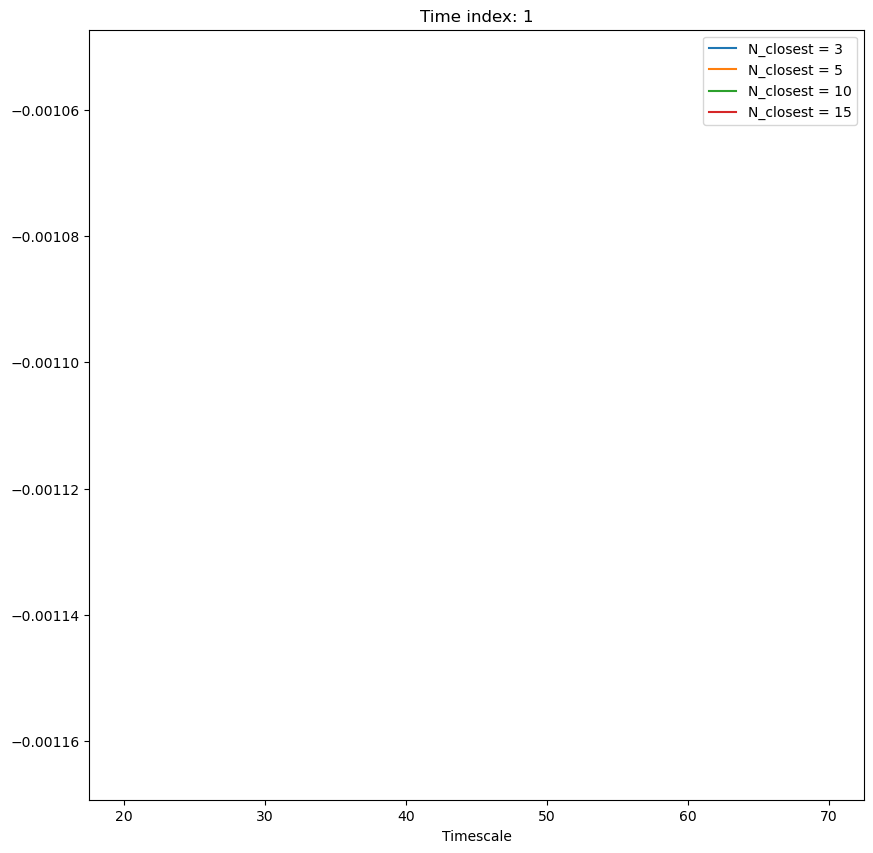

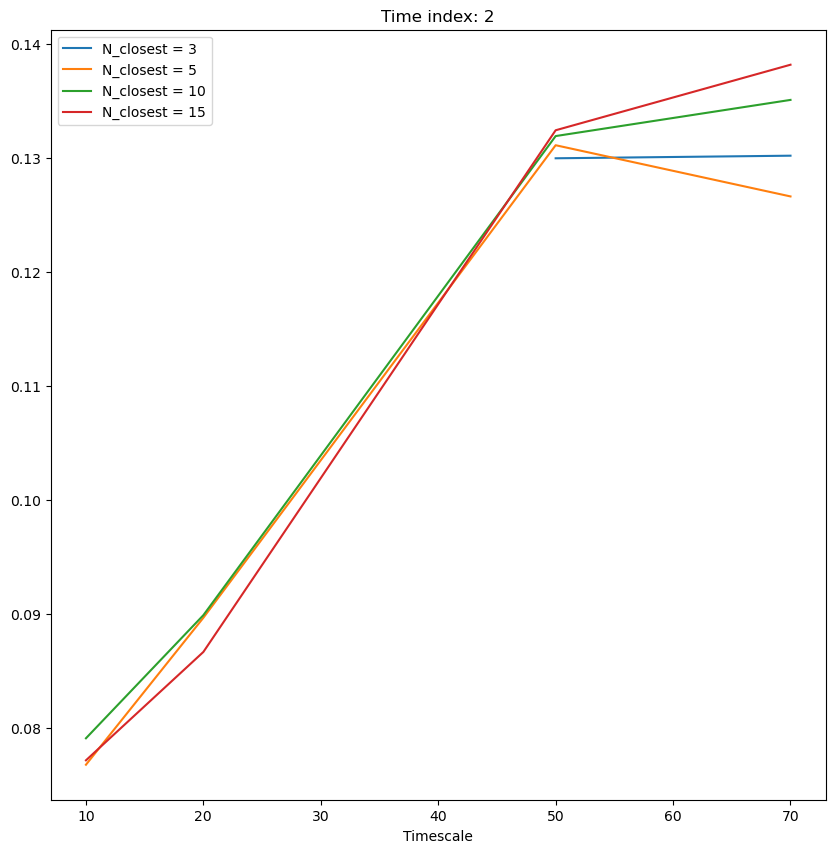

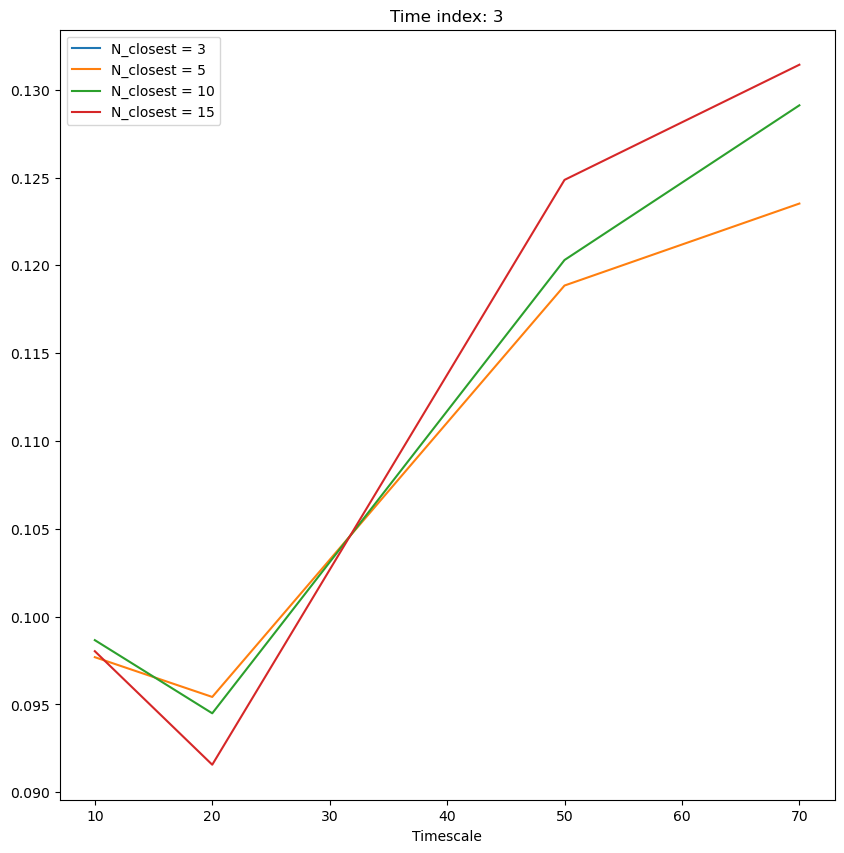

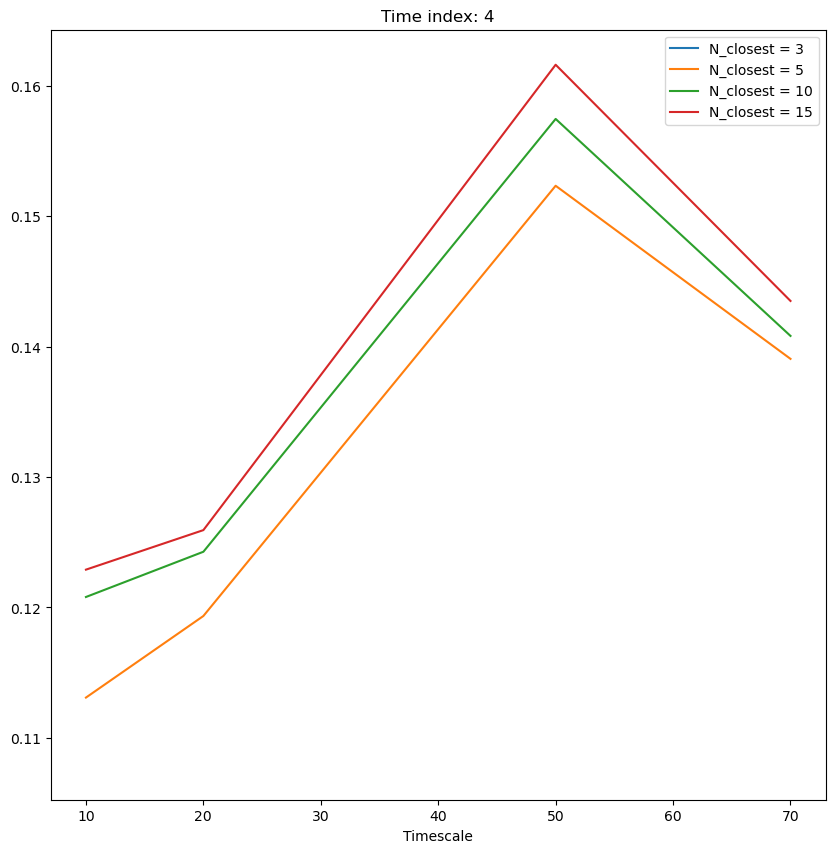

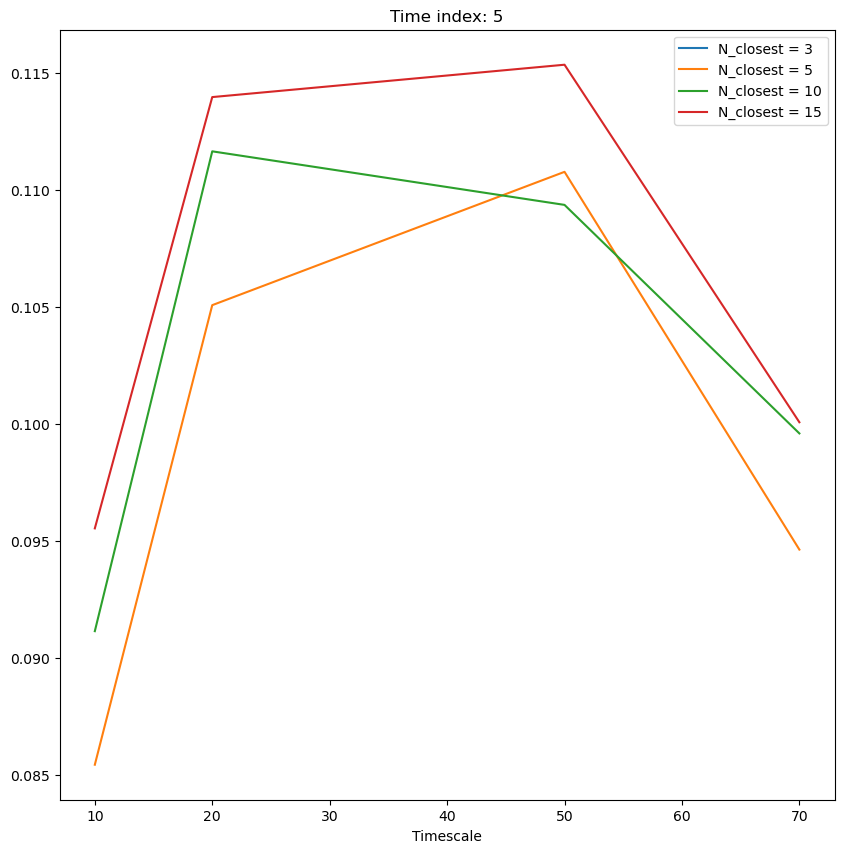

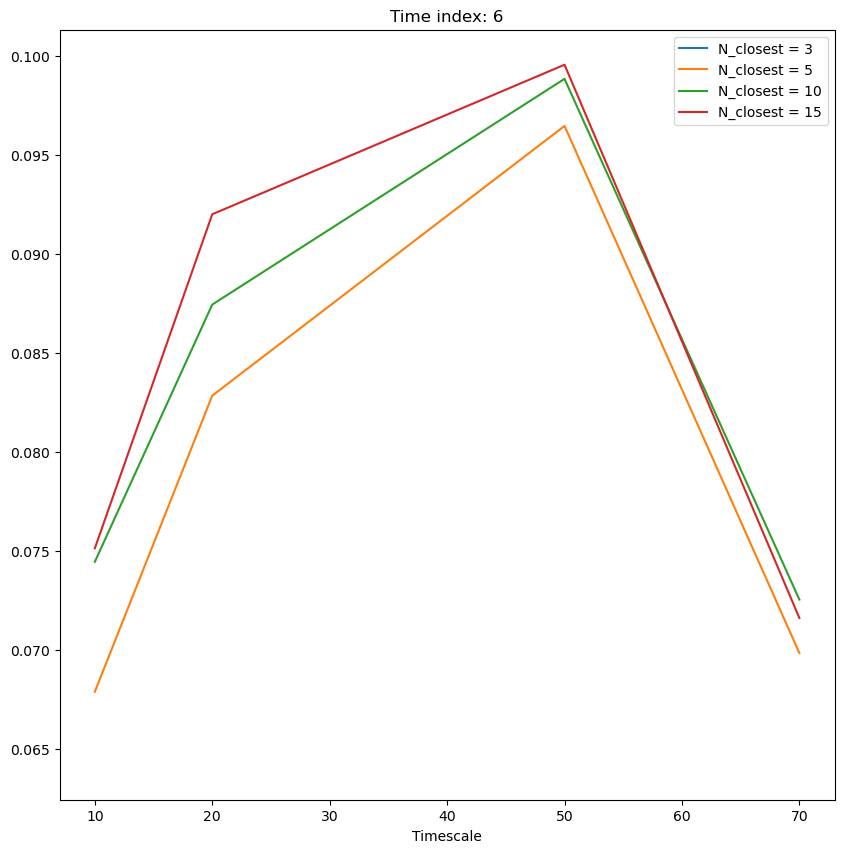

In [254]:
for i, time_index in enumerate(time_indices):
    plt.figure(figsize = (10,10))
    plt.title(f"Time index: {time_index}")
    for j, N in enumerate(N_closest):
        plt.plot(timescales, overview[i,j], label = f"N_closest = {N}")

    plt.xlabel('Timescale')
    plt.legend()
    plt.show()

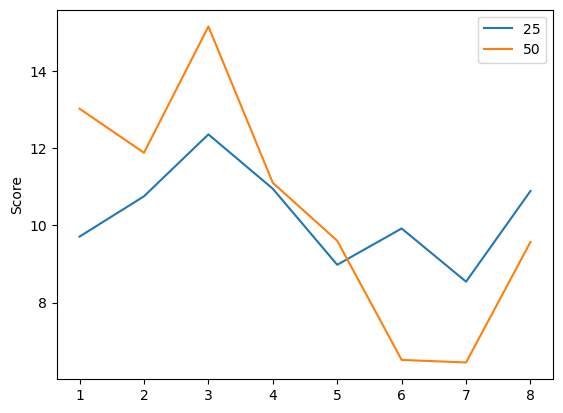

In [246]:
plt.plot(np.array(ss)*100, label = '25')
plt.plot(np.array(ss50)*100, label = '50')
plt.ylabel('Score')
plt.legend()
plt.show()

No handles with labels found to put in legend.


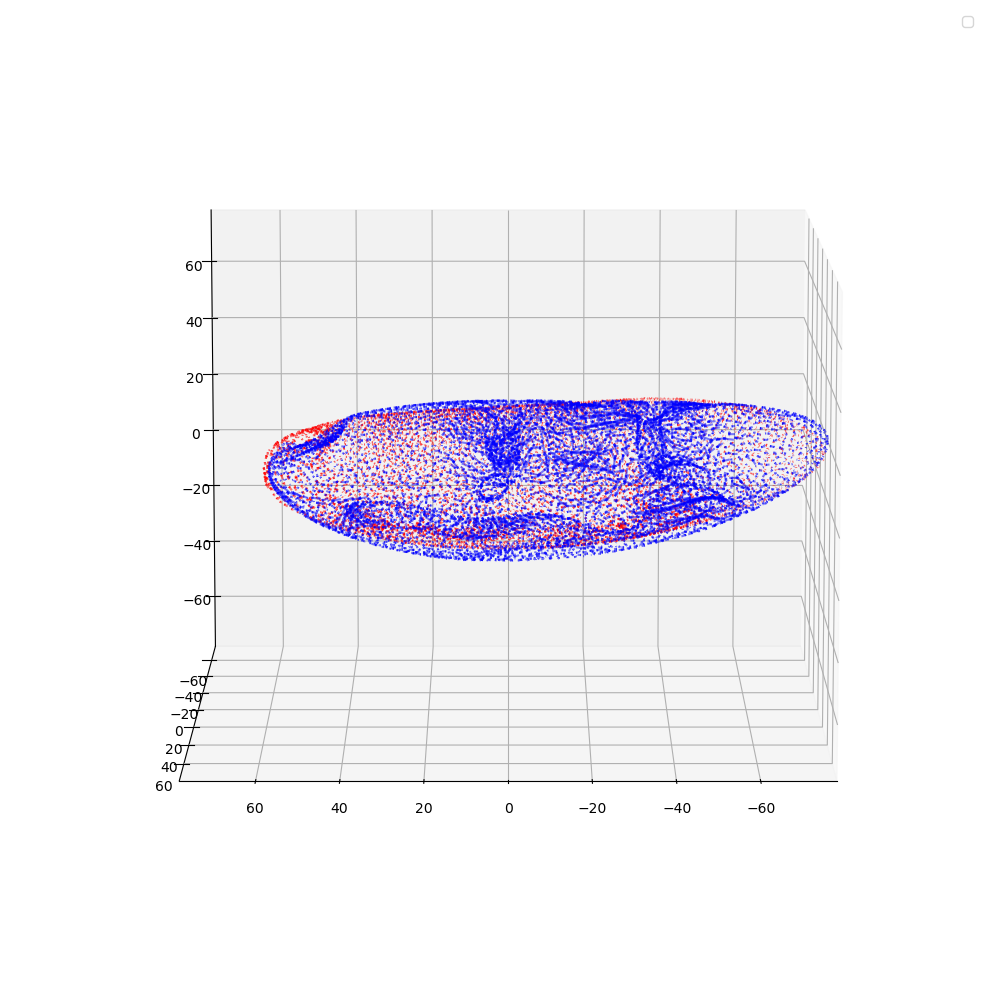

In [235]:
# draw quiver plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tracked_and_rescaled = pd.read_csv('../DeconstructingGastrulation-Data/tracked_data_rescaled.csv')

fig = plt.figure(figsize = (10,10), tight_layout = True)
ax = fig.add_subplot(111, projection='3d',)
frame1 = tracked_and_rescaled[tracked_and_rescaled['frame'] == 5]

# ax.scatter(frame1['x'], frame1['y'], frame1['z'], c='r', marker='.', alpha = 1, label = 'Stas', s = 40, edgecolors='k', zorder = 10)
ax.quiver(frame1['x'], frame1['y'], frame1['z'], frame1['dx'], frame1['dy'], frame1['dz'], color = 'r', alpha = 0.5)


x,y,z = sim[5*50].T

d = sim[6*50].T - sim[5*50].T
# ax.scatter(x, y, z, c='b', marker='.', alpha = 1, label = 'Simulation', s = 40, edgecolors='k')
ax.quiver(x, y, z, d[0], d[1], d[2], color = 'b', alpha = 0.5)

plt.xlim(-75,75)

plt.ylim(-75,75)
ax.set_zlim(-75,75)

# set the camera angle
ax.view_init(elev=10, azim=90)

plt.legend()
plt.show()
# draw quiver plot